In [22]:
# Run this cell first - DO NOT MODIFY
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import resample
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler

# Set random seed for reproducibility
np.random.seed(42)

# Set plot style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)

print("Setup complete!")

Setup complete!


In [24]:

df =  pd.read_csv('insuranceWithFeatures.csv')

In [26]:
print(df.head())

   age     sex     bmi  children smoker     region      charges  smoker-age  \
0   19  female  27.900         0    yes  southwest  16884.92400          19   
1   18    male  33.770         1     no  southeast   1725.55230           0   
2   28    male  33.000         3     no  southeast   4449.46200           0   
3   33    male  22.705         0     no  northwest  21984.47061           0   
4   32    male  28.880         0     no  northwest   3866.85520           0   

   Sex-Weight  sexBool  smokerBool  regionSouthWest  regionSouthEast  \
0        27.9        1           1                1                0   
1         0.0        0           0                0                1   
2         0.0        0           0                0                1   
3         0.0        0           0                0                0   
4         0.0        0           0                0                0   

   regionNorthWest  log_charges  
0                0     9.734236  
1                0     7

In [28]:
feature_col = ['age', 'bmi', 'children', 'sexBool', 'smokerBool', 'Sex-Weight', 'smoker-age', 'regionSouthWest', 'regionSouthEast', 'regionNorthWest']
X_multi = df[feature_col].values
y = df['charges'].values
# no bootstrap

#Scaled data for ridge regressions penalty (not necessary for linear regression)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_multi)
# Train/test split 80 - 20, random state 42 for reproductivity
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2)
#Apha values for ridge
alphas = [4.4, 4.5, 4.6, 4.7]

ridge = Ridge()
    # gridsearch cross validation = 5
grid = GridSearchCV(ridge, param_grid={'alpha': alphas}, cv=5, scoring='r2')
grid.fit(X_train, y_train)

print("Best alpha (baseline):", grid.best_params_)

y_pred_test = grid.predict(X_test)

print("Baseline Test R^2:", r2_score(y_test, y_pred_test))
print("Baseline MAE:", mean_absolute_error(y_test, y_pred_test))
print("Baseline MSE:", mean_squared_error(y_test, y_pred_test))

#bootsrap num
n_bootstrap = 1000
#use boostrap on these metrics
r2_list = []
mae_list = []
mse_list = []
coef_list = []

for i in range(n_bootstrap):

    df_boot = resample(df, replace=True, n_samples=len(df), random_state=i)

    X_boot = df_boot[feature_col].values
    y_boot = df_boot['charges'].values

    # Train/test split 80 - 20, random state 42 for reproductivity
    X_train, X_test, y_train, y_test = train_test_split(
        X_boot, y_boot, test_size=0.2)

    #Scaled data for ridge regressions penalty (not necessary for linear regression)
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # gridsearch
    ridge = Ridge()
    grid = GridSearchCV(ridge, {'alpha': alphas}, cv=5, scoring='r2')
    grid.fit(X_train_scaled, y_train)

    best_model = grid.best_estimator_

    # predictions
    y_pred = best_model.predict(X_test_scaled)

    r2_list.append(r2_score(y_test, y_pred))
    mae_list.append(mean_absolute_error(y_test, y_pred))
    mse_list.append(mean_squared_error(y_test, y_pred))

    coef_list.append(best_model.coef_)

#use function to not repeat code for each array
def ci(arr):
    lower = np.percentile(arr, 2.5)
    upper = np.percentile(arr, 97.5)
    return lower, upper

print(f"\nBootstrap results ({n_bootstrap} resamples):")
print("R^2 CI:", ci(r2_list))
print("MAE CI:", ci(mae_list))
print("MSE CI:", ci(mse_list))

#needed help from AI for the coeficient CI
coef_array = np.array(coef_list)

print("\nCoefficient 95% Confidence Intervals:")
for i, name in enumerate(feature_col):
    lower = np.percentile(coef_array[:, i], 2.5)
    upper = np.percentile(coef_array[:, i], 97.5)
    print(f"{name}: ({lower:.3f}, {upper:.3f})")

#print("Best alpha:", grid.best_params_)
#print("Test R^2:", grid.score(X_test, y_test))
#used code from previous assignment for next part
# Make predictions
#y_pred_train_multi = grid.predict(X_train)
#y_pred_test_multi = grid.predict(X_test)
# Calculate metrics


Best alpha (baseline): {'alpha': 4.5}
Baseline Test R^2: 0.7821344268148182
Baseline MAE: 4198.138528031593
Baseline MSE: 33823353.87272763

Bootstrap results (1000 resamples):
R^2 CI: (0.6732262654942153, 0.8043975017737173)
MAE CI: (3638.5018507510963, 4731.338678348909)
MSE CI: (28046353.700788725, 46899945.992284626)

Coefficient 95% Confidence Intervals:
age: (3060.110, 3798.099)
bmi: (1563.262, 2587.074)
children: (229.337, 925.075)
sexBool: (-1398.327, 1690.355)
smokerBool: (7176.208, 9950.419)
Sex-Weight: (-1706.130, 1548.174)
smoker-age: (-292.269, 2421.507)
regionSouthWest: (-814.126, -2.132)
regionSouthEast: (-938.012, 3.842)
regionNorthWest: (-588.864, 306.995)


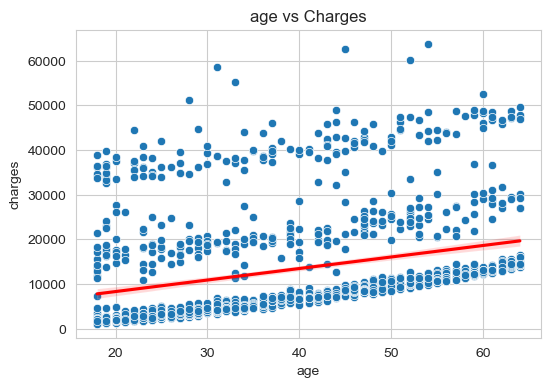

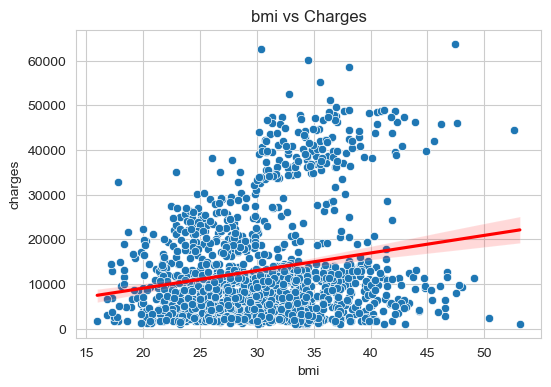

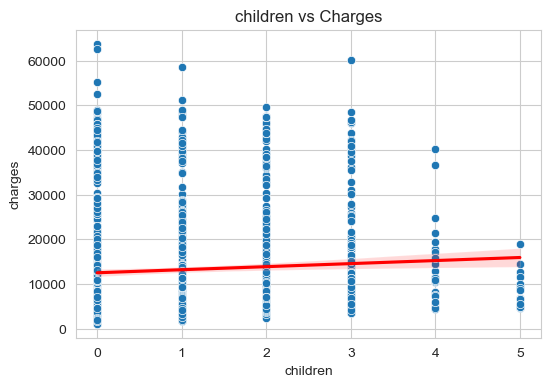

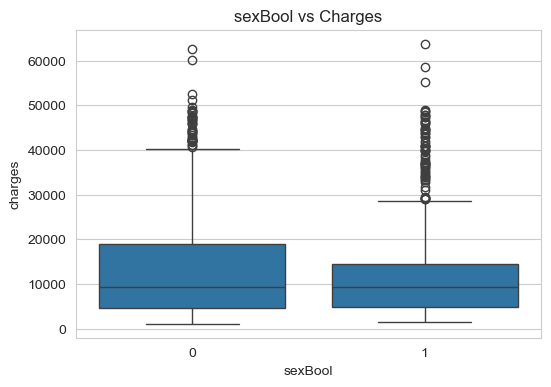

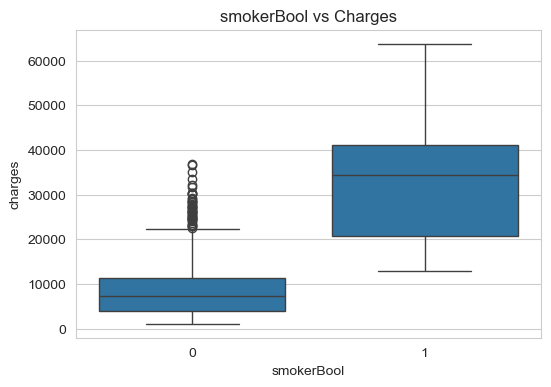

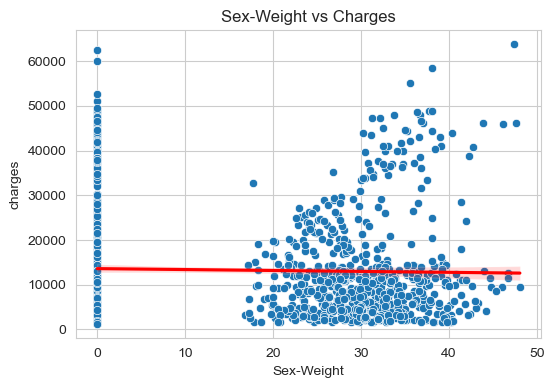

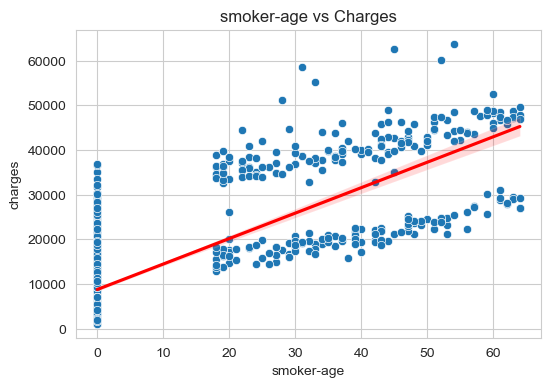

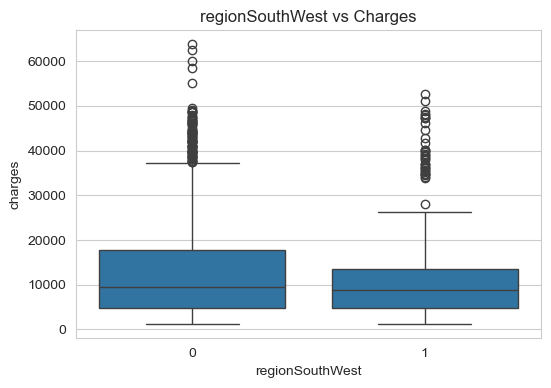

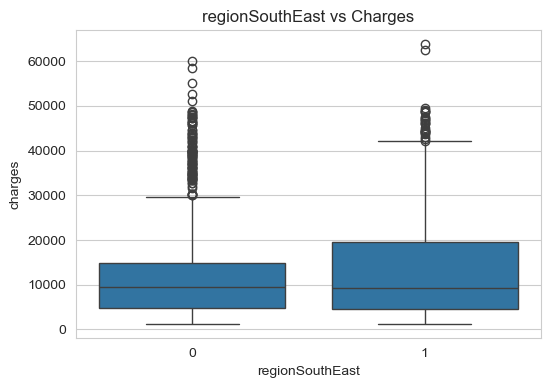

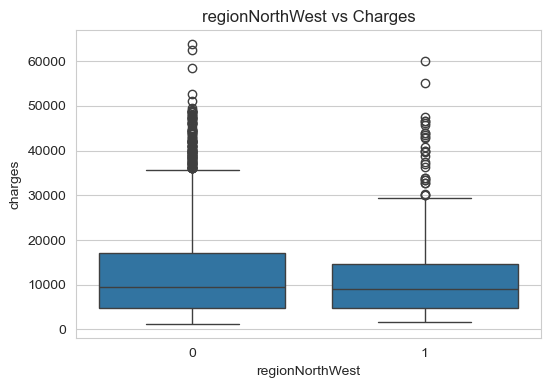

In [30]:
#My plots were ugly so I used AI to clean them up
for feature in feature_col:
    plt.figure(figsize=(6,4))
    if df[feature].nunique() <= 5:  # categorical/binary
        sns.boxplot(x=feature, y='charges', data=df)
    else:  # continuous
        sns.scatterplot(x=feature, y='charges', data=df)
        sns.regplot(x=feature, y='charges', data=df, scatter=False, color='red')
    plt.title(f"{feature} vs Charges")
    plt.show()

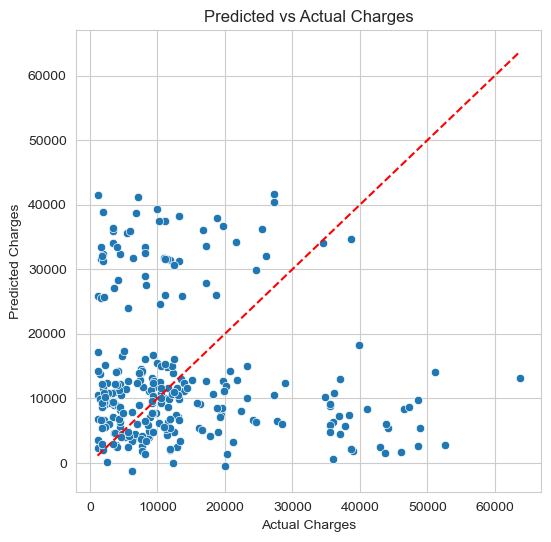

In [32]:
plt.figure(figsize=(6,6))
sns.scatterplot(x=y_test, y=y_pred_test_multi)
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         color='red', linestyle='--')
plt.xlabel("Actual Charges")
plt.ylabel("Predicted Charges")
plt.title("Predicted vs Actual Charges")
plt.show()

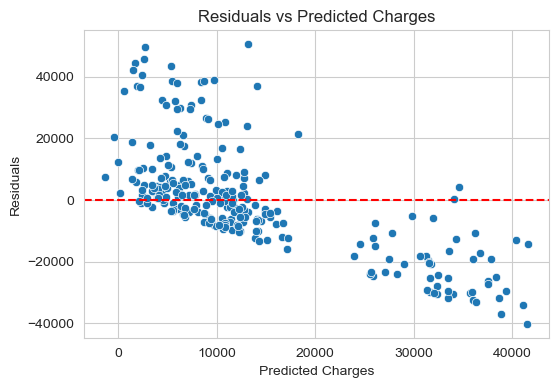

In [34]:
residuals = y_test - y_pred_test_multi
plt.figure(figsize=(6,4))
sns.scatterplot(x=y_pred_test_multi, y=residuals)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted Charges")
plt.ylabel("Residuals")
plt.title("Residuals vs Predicted Charges")
plt.show()

In [36]:
#Displaying each features coefficient for the model
best_ridge = grid.best_estimator_
beta_scaled = best_ridge.coef_
intercept_scaled = best_ridge.intercept_
#need to unscale the model to get formula (needed help from AI because it wasn't working for me)
means = scaler.mean_
scales = scaler.scale_
beta_original = beta_scaled / scales
intercept_original = intercept_scaled - np.sum((beta_scaled * means) / scales)
for name, coef in zip(feature_col, beta_original):
    print(f"{name}: {coef:.2f}")

print("Intercept:", intercept_original)

age: 255.39
bmi: 245.00
children: 691.44
sexBool: -3304.35
smokerBool: 20207.46
Sex-Weight: 124.75
smoker-age: 60.68
regionSouthWest: -1702.89
regionSouthEast: -880.32
regionNorthWest: -482.40
Intercept: -9111.382430236796


The formula for this model is Charge = 255.39*age + 245.00*BMI + 691.44*children# - 3304.35*isFemale + 20207.46*isSmoker + 124.75*womenBMI + 60.68*smokerage -1702.89*southwest - 880.32*southeast - 482.40*northwest - -9111.38

the womenBMI just means that women get charged less than men as the BMI increases.

The region means that north east is the most expensive region followed by northwest, southeast, then southwest is the cheapest.